In [2]:
!pip install -U scikit-learn
!pip install autograd

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 829 kB 3.8 MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=e9c0746271c6aa21141bde5d548c5aef033b59159c0963cf001224471ab86ca4
  Stored in directory: /Users/jordivitria/Library/Caches/pip/wheels/85/f5/d2/3ef47d3a836b17620bf41647222825b065245862d12aa62885
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=7e86447658cfd30979264565767801badd3c7668e4549befe2f5583f4ae52d62
  Stored in directory: /Users/jordivitria/Library/Caches/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built autograd future
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

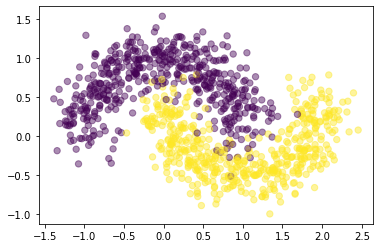

In [1]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = \mbox{softmax}({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [2]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


In [3]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [4]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.579072
Loss after iteration 1000: 0.318194
Loss after iteration 2000: 0.297823
Loss after iteration 3000: 0.292968
Loss after iteration 4000: 0.289702
Loss after iteration 5000: 0.286239
Loss after iteration 6000: 0.282110
Loss after iteration 7000: 0.277041
Loss after iteration 8000: 0.270838
Loss after iteration 9000: 0.263436
Loss after iteration 10000: 0.254934
Loss after iteration 11000: 0.245598
Loss after iteration 12000: 0.235800
Loss after iteration 13000: 0.225928
Loss after iteration 14000: 0.216313
Loss after iteration 15000: 0.207199
Loss after iteration 16000: 0.198736
Loss after iteration 17000: 0.190997
Loss after iteration 18000: 0.183991
Loss after iteration 19000: 0.177694
Loss after iteration 20000: 0.172053
Loss after iteration 21000: 0.167009
Loss after iteration 22000: 0.162497
Loss after iteration 23000: 0.158456
Loss after iteration 24000: 0.154825
Loss after iteration 25000: 0.151550
Loss after iteration 26000: 0.148580
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

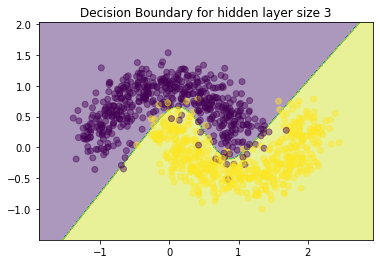

In [5]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


In [6]:
# your code here

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 


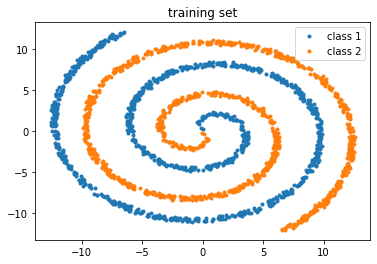

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [8]:
# your code here